In [3]:
!wget --quiet \
 http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py

In [2]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [4]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

2020-12-21 15:19:24.931 | INFO     | torch_snippets.loader:Glob:190 - 20210 files found at images/training
2020-12-21 15:19:24.957 | INFO     | torch_snippets.loader:Glob:190 - 20210 files found at annotations_instance/training


2020-12-21 15:19:33.808 | INFO     | torch_snippets.loader:subplots:385 - plotting 5 images in a grid of 1x5 @ (5, 5)


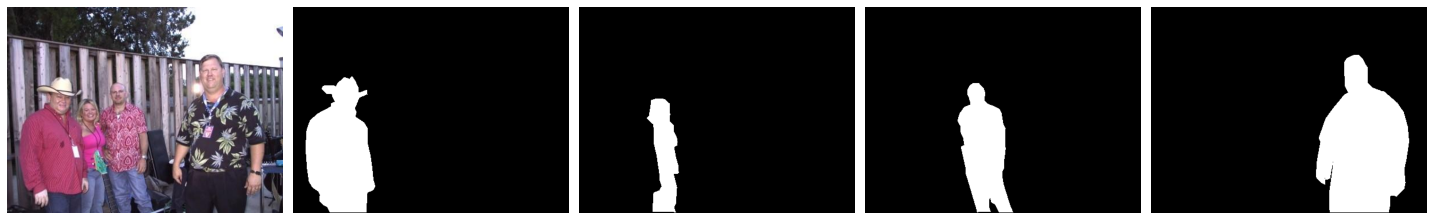

In [5]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [6]:
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 20210/20210 [01:15<00:00, 266.44it/s]


In [7]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items,val_items=train_test_split(_annots,random_state=2)

In [8]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [20]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
            nzs = np.nonzero(r==_cls)
            instances = np.unique(g[nzs])
            for ix,_id in enumerate(instances):
                masks.append(g==_id)
                labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * 
                    (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]


SyntaxError: invalid syntax (<ipython-input-20-c46802bdfc83>, line 42)

2020-12-21 15:34:57.364 | INFO     | torch_snippets.loader:subplots:385 - plotting 4 images in a grid of 1x5 @ (5, 5)


Tensor	Shape: torch.Size([3, 512, 683])	Min: 0.000	Max: 1.000	Mean: 0.468	dtype: torch.float32
Dict Of 6 items
	BOXES:
	Tensor	Shape: torch.Size([3, 4])	Min: 255.000	Max: 681.000	Mean: 412.417	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([3])	Min: 1.000	Max: 1.000	Mean: 1.000	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([3, 512, 683])	Min: 0.000	Max: 1.000	Mean: 0.024	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([3])	Min: 363.000	Max: 20172.000	Mean: 11981.667	dtype: torch.float32
... ... 1 more items


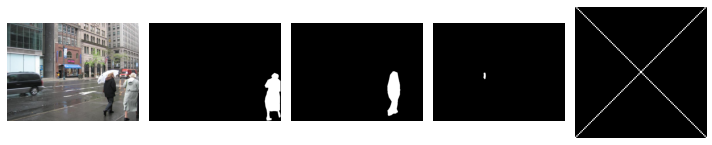

In [11]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [12]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on 
    # COCO
    model = torchvision.models.detection\
                       .maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads\
                       .box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(\
                                    in_features,num_classes)
    in_features_mask = model.roi_heads\
                       .mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(\
                                      in_features_mask,\
                                   hidden_layer, num_classes)
    return model

In [13]:
model = get_model_instance_segmentation(2).to(device)
model

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/pedro/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [ ]:
dataset = MasksDataset(trn_items, get_transform(train=True), \
                                                    N=3000)
dataset_test = MasksDataset(val_items, \
                           get_transform(train=False), N=800)

# define training and validation data loaders
data_loader=torch.utils.data.DataLoader(dataset,batch_size=2, \
                                shuffle=True, num_workers=0, \
                                 collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, \
                                batch_size=1, shuffle=False, \
                   num_workers=0,collate_fn=utils.collate_fn)

In [ ]:
num_classes = 2
model = get_model_instance_segmentation(\
                        num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, \
                            momentum=0.9,weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, \
                                                step_size=3,

In [ ]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, \
                          device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

In [ ]:
model.eval()
im = dataset_test[0][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks']\
                      [i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels']\
                   [i].cpu().numpy())+' Score:'+str(\
                  prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

In [ ]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in \
                classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, \
                                     random_state=2)

In [ ]:
num_classes = 3
model=get_model_instance_segmentation(num_classes).to(device)